# Most Complex Greetings

How can we convey season greetings in purely mathematical way?

Let's use Fourier Series !!!

$$ 
f(t) = \sum_{n={-\infty}}^\infty c_ne^{2\pi n \frac tL}
$$

$$
c_n = \frac1L\int_{-\frac1L}^\frac1L f(t) e^{-2\pi n \frac tL} \, dt
$$


In [1]:
# magic functions

# load code prifler extension
%load_ext line_profiler
# load Cython extension
%load_ext Cython
# setup backend for matplotlibs plots
%matplotlib inline

In [2]:
%%cython
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

cimport cython

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
cimport numpy as np
import sympy as sp
from sklearn import preprocessing

def loadFile(fileName):
    return pd.read_csv(fileName) 

def normalizePoints(dataFrame):
    names = dataFrame.columns
    scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(dataFrame)        
    return pd.DataFrame(scaled_df, columns=names)

def addHelperColumns(dataFrame,int points):
    dataFrame['z'] = dataFrame['x'].values + dataFrame['y'].values * 1j
    dataFrame['time'] = dataFrame.apply(lambda row: row.name/points,  axis=1)
    
def c_n_row(np.ndarray z,np.ndarray t,int n, int points):
    cc = np.exp(-n*2*np.pi*t*1j) 
    return z*cc/points   

@cython.boundscheck(False)
@cython.wraparound(False)
def processPoints(dataFrame,int terms,int points):        
    cdef np.ndarray counts = np.zeros((terms,1), dtype=complex)
    
    for i in range(terms):
        c_terms = c_n_row(dataFrame['z'].values,dataFrame['time'].values,i,points)
        counts[i] = points/len(c_terms) * np.sum(c_terms)
        
    return counts 

@cython.boundscheck(False)
@cython.wraparound(False)
def processCounts(int points, np.ndarray counts):
    t,c,n= sp.symbols("t c n")
    
    expr = c*sp.exp(n*2*sp.pi*t*1j)
    lamb_formula = sp.lambdify([c,n,t], expr,'numpy')

    cdef np.ndarray index = np.arange(len(counts), dtype=int).reshape(len(counts),1)
    cdef np.ndarray p = np.zeros((2,points),dtype=float)
    
    for i in range(points):
        terms = lamb_formula(counts,index,i/points)

        v = np.sum(terms)

        p[0][i] = np.real(v)
        p[1][i] = np.imag(v)
            
    return p

@cython.boundscheck(False)
@cython.wraparound(False)
def processCountsPoints(int points,np.ndarray counts):
    t,c,n= sp.symbols("t c n")
    
    expr = c*sp.exp(n*2*sp.pi*t*1j)
    lamb_formula = sp.lambdify([c,n,t], expr,'numpy')
  
    ncounts = len(counts)

    cdef np.ndarray p = np.zeros((points,ncounts),dtype=complex)
    cdef np.ndarray index = np.arange(ncounts, dtype=int).reshape(ncounts,1)
    cdef np.ndarray points_x_y = np.zeros((points,2,ncounts),dtype=float)
    
    for i in range(points):
        points_x = np.zeros(ncounts)
        points_y = np.zeros(ncounts)
        
        terms = lamb_formula(counts,index,i/points)
        
        p[i,:] = terms.reshape(ncounts)
        
        for j in range(ncounts):
            tp = np.sum(p[i][0:j+1:1])
            points_x_y[i][0][j] = np.real(tp)
            points_x_y[i][1][j] = np.imag(tp)
        
    return points_x_y   

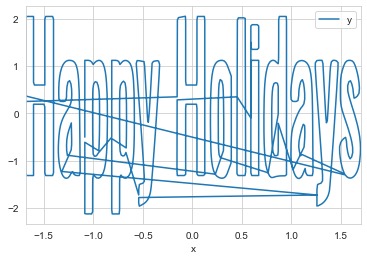

In [3]:
sns.set_style("whitegrid")

df = loadFile('happyholidays-20.csv')

points = len(df.index)
points_to_use = 1
cn_count = int(points * points_to_use)

df.plot(kind='line',x='x',y='y')

df = normalizePoints(df)

df.plot(kind='line',x='x',y='y')

df['y'] = -1*df['y']

df.plot(kind='line',x='x',y='y')

addHelperColumns(df,points)

In [4]:
%lprun -f processPoints counts = processPoints(df,cn_count,points)

Timer unit: 1e-06 s

Total time: 0.102259 s
File: /Users/patrykattc/.ipython/cython/_cython_magic_d140cd323b1bc3b04ce41be3098a9206.pyx
Function: processPoints at line 36

Line #      Hits         Time  Per Hit   % Time  Line Contents
    36                                           def processPoints(dataFrame,int terms,int points):        
    37         1         28.0     28.0      0.0      cdef np.ndarray counts = np.zeros((terms,1), dtype=complex)
    38                                               
    39         1          1.0      1.0      0.0      for i in range(terms):
    40      1301      87258.0     67.1     85.3          c_terms = c_n_row(dataFrame['z'].values,dataFrame['time'].values,i,points)
    41      1301      14972.0     11.5     14.6          counts[i] = points/len(c_terms) * np.sum(c_terms)
    42                                                   
    43         1          0.0      0.0      0.0      return counts

In [5]:
%lprun -f processCounts data = processCounts(points,counts)

Timer unit: 1e-06 s

Total time: 0.095745 s
File: /Users/patrykattc/.ipython/cython/_cython_magic_d140cd323b1bc3b04ce41be3098a9206.pyx
Function: processCounts at line 47

Line #      Hits         Time  Per Hit   % Time  Line Contents
    47                                           def processCounts(int points, np.ndarray counts):
    48         1        169.0    169.0      0.2      t,c,n= sp.symbols("t c n")
    49                                               
    50         1      14436.0  14436.0     15.1      expr = c*sp.exp(n*2*sp.pi*t*1j)
    51         1       4541.0   4541.0      4.7      lamb_formula = sp.lambdify([c,n,t], expr,'numpy')
    52                                           
    53         1         17.0     17.0      0.0      cdef np.ndarray index = np.arange(len(counts), dtype=int).reshape(len(counts),1)
    54         1          5.0      5.0      0.0      cdef np.ndarray p = np.zeros((2,points),dtype=float)
    55                                               
 

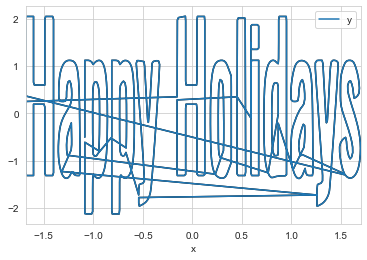

In [6]:
fig, ax = plt.subplots()
#ax.scatter(data[0],data[1],color="black",s=1)
ax.plot(data[0],data[1],color="black")
df.plot(kind='line',x='x',y='y',ax=ax)
plt.show() 

In [7]:
%lprun -f processCountsPoints points_x_y = processCountsPoints(points,counts)

Timer unit: 1e-06 s

Total time: 14.4094 s
File: /Users/patrykattc/.ipython/cython/_cython_magic_d140cd323b1bc3b04ce41be3098a9206.pyx
Function: processCountsPoints at line 68

Line #      Hits         Time  Per Hit   % Time  Line Contents
    68                                           def processCountsPoints(int points,np.ndarray counts):
    69         1         95.0     95.0      0.0      t,c,n= sp.symbols("t c n")
    70                                               
    71         1        355.0    355.0      0.0      expr = c*sp.exp(n*2*sp.pi*t*1j)
    72         1       2815.0   2815.0      0.0      lamb_formula = sp.lambdify([c,n,t], expr,'numpy')
    73                                             
    74         1         10.0     10.0      0.0      ncounts = len(counts)
    75                                           
    76         1         33.0     33.0      0.0      cdef np.ndarray p = np.zeros((points,ncounts),dtype=complex)
    77         1         15.0     15.0      

In [8]:
import matplotlib.animation as animation
import matplotlib.image as image

sns.set(style="ticks")

im = image.imread('logo.png')

fig,ax = plt.subplots()
fig.suptitle('Most Complex Greetings', fontsize=20)
fig.figimage(im, 400,60, zorder=3)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid(False)

ax.plot(data[0],data[1],color="grey", alpha=0.4)
#df.plot(kind='line',x='x',y='y',ax=ax, alpha=0.4)

line1, = ax.plot([],[],color="black", linewidth=1)
line2, = ax.plot([],[],color="green", linewidth=1)

s_points_x = []
s_points_y = []
    
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1,line2

def animate(i):
    s_points_x.append(points_x_y[i][0][-1])
    s_points_y.append(points_x_y[i][1][-1])
    line1.set_data(points_x_y[i][0], points_x_y[i][1])
    line2.set_data(s_points_x,s_points_y)  
    return line1,line2,

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=points, interval=200, blit=True)

anim.save('greetings.mp4',dpi=100)
#anim.save('test.gif', writer='imagemagick')